In [1]:
import numpy as np
import scipy.optimize
import pickle
import numpy as np
import cv2
import glob
import camutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
#calibrate.py

In [3]:
# file names, modify as necessary
calibimgfiles = '/Users/cememirsenyurt/Desktop/CS117FINAL/calib_jpg_u/*.jpg'
resultfile = 'calibration.pickle'

# checkerboard coordinates in 3D
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = 2.8*np.mgrid[0:8, 0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(calibimgfiles)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Display image with the corners overlayed
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# now perform the calibration
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print("Estimated camera intrinsic parameter matrix K")
print(K)
print("Estimated radial distortion coefficients")
print(dist)

print("Individual intrinsic parameters")
print("fx = ",K[0][0])
print("fy = ",K[1][1])
print("cx = ",K[0][2])
print("cy = ",K[1][2])


# save the results out to a file for later use
calib = {}
calib["fx"] = K[0][0]
calib["fy"] = K[1][1]
calib["cx"] = K[0][2]
calib["cy"] = K[1][2]
calib["dist"] = dist
fid = open(resultfile, "wb" ) 
pickle.dump(calib,fid)
fid.close()

Estimated camera intrinsic parameter matrix K
[[1.40530791e+03 0.00000000e+00 9.62167368e+02]
 [0.00000000e+00 1.40389402e+03 5.90915958e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Estimated radial distortion coefficients
[[-5.23053804e-03  8.05964656e-02  2.01739363e-05 -3.90735937e-03
  -1.08096612e-01]]
Individual intrinsic parameters
fx =  1405.3079110142996
fy =  1403.894021882494
cx =  962.1673683350518
cy =  590.915957777223


In [4]:
# camutils.py

In [5]:
def makerotation(rx,ry,rz):
    """
    Generate a rotation matrix    

    Parameters
    ----------
    rx,ry,rz : floats
        Amount to rotate around x, y and z axes in degrees

    Returns
    -------
    R : 2D numpy.array (dtype=float)
        Rotation matrix of shape (3,3)
    """
    rx = np.pi*rx/180.0
    ry = np.pi*ry/180.0
    rz = np.pi*rz/180.0

    Rx = np.array([[1,0,0],[0,np.cos(rx),-np.sin(rx)],[0,np.sin(rx),np.cos(rx)]])
    Ry = np.array([[np.cos(ry),0,-np.sin(ry)],[0,1,0],[np.sin(ry),0,np.cos(ry)]])
    Rz = np.array([[np.cos(rz),-np.sin(rz),0],[np.sin(rz),np.cos(rz),0],[0,0,1]])
    R = (Rz @ Ry @ Rx)
    
    return R 

class Camera:
    """
    A simple data structure describing camera parameters 
    
    The parameters describing the camera
    cam.f : float   --- camera focal length (in units of pixels)
    cam.c : 2x1 vector  --- offset of principle point
    cam.R : 3x3 matrix --- camera rotation
    cam.t : 3x1 vector --- camera translation 

    
    """    
    def __init__(self,f,c,R,t):
        self.f = f
        self.c = c
        self.R = R
        self.t = t

    def __str__(self):
        return f'Camera : \n f={self.f} \n c={self.c.T} \n R={self.R} \n t = {self.t.T}'
    
    def project(self,pts3):
        """
        Project the given 3D points in world coordinates into the specified camera    

        Parameters
        ----------
        pts3 : 2D numpy.array (dtype=float)
            Coordinates of N points stored in a array of shape (3,N)

        Returns
        -------
        pts2 : 2D numpy.array (dtype=float)
            Image coordinates of N points stored in an array of shape (2,N)

        """
        assert(pts3.shape[0]==3)

        # get point location relative to camera
        pcam = self.R.transpose() @ (pts3 - self.t)
         
        # project
        p = self.f * (pcam / pcam[2,:])
        
        # offset principal point
        pts2 = p[0:2,:] + self.c
        
        assert(pts2.shape[1]==pts3.shape[1])
        assert(pts2.shape[0]==2)
    
        return pts2
 
    def update_extrinsics(self,params):
        """
        Given a vector of extrinsic parameters, update the camera
        to use the provided parameters.
  
        Parameters
        ----------
        params : 1D numpy.array (dtype=float)
            Camera parameters we are optimizing over stored in a vector
            params[0:2] are the rotation angles, params[2:5] are the translation

        """
        self.R = makerotation(params[0],params[1],params[2])
        self.t = np.array([[params[3]],[params[4]],[params[5]]])


def triangulate(pts2L,camL,pts2R,camR):
    """
    Triangulate the set of points seen at location pts2L / pts2R in the
    corresponding pair of cameras. Return the 3D coordinates relative
    to the global coordinate system


    Parameters
    ----------
    pts2L : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N) seen from camL camera

    pts2R : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N) seen from camR camera

    camL : Camera
        The first "left" camera view

    camR : Camera
        The second "right" camera view

    Returns
    -------
    pts3 : 2D numpy.array (dtype=float)
        (3,N) array containing 3D coordinates of the points in global coordinates

    """

    npts = pts2L.shape[1]

    qL = (pts2L - camL.c) / camL.f
    qL = np.vstack((qL,np.ones((1,npts))))

    qR = (pts2R - camR.c) / camR.f
    qR = np.vstack((qR,np.ones((1,npts))))
    
    R = camL.R.T @ camR.R
    t = camL.R.T @ (camR.t-camL.t)

    xL = np.zeros((3,npts))
    xR = np.zeros((3,npts))

    for i in range(npts):
        A = np.vstack((qL[:,i],-R @ qR[:,i])).T
        z,_,_,_ = np.linalg.lstsq(A,t,rcond=None)
        xL[:,i] = z[0]*qL[:,i]
        xR[:,i] = z[1]*qR[:,i]
 
    pts3L = camL.R @ xL + camL.t
    pts3R = camR.R @ xR + camR.t
    pts3 = 0.5*(pts3L+pts3R)

    return pts3


def residuals(pts3,pts2,cam,params):
    """
    Compute the difference between the projection of 3D points by the camera
    with the given parameters and the observed 2D locations

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    params : 1D numpy.array (dtype=float)
        Camera parameters we are optimizing over stored in a vector

    Returns
    -------
    residual : 1D numpy.array (dtype=float)
        Vector of residual 2D projection errors of size 2*N
        
    """

    cam.update_extrinsics(params)
    residual = pts2 - cam.project(pts3)
    
    return residual.flatten()

def calibratePose(pts3,pts2,cam_init,params_init):
    """
    Calibrate the provided camera by updating R,t so that pts3 projects
    as close as possible to pts2

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    cam : Camera
        Initial estimate of camera

    Returns
    -------
    cam_opt : Camera
        Refined estimate of camera with updated R,t parameters
        
    """

    # define our error function
    efun = lambda params: residuals(pts3,pts2,cam_init,params)        
    popt,_ = scipy.optimize.leastsq(efun,params_init)
    cam_init.update_extrinsics(popt)

    return cam_init


def decode(imprefix,start,threshold):
    """
    Decode 10bit gray code pattern with the given difference
    threshold.  We assume the images come in consective pairs
    with filenames of the form <prefix><start>.png - <prefix><start+20>.png
    (e.g. a start offset of 20 would yield image20.png, image01.png... image39.png)

    Parameters
    ----------
    imprefix : str
      prefix of where to find the images (assumed to be .png)

    start : int
      image offset.  

    threshold : float

    Returns
    -------
    code : 2D numpy.array (dtype=float)
        
    mask : 2D numpy.array (dtype=float)
    
    
    """
    nbits = 10
    
    imgs = list()
    imgs_inv = list()
    print('loading',end='')
    for i in range(start,start+2*nbits,2):
        fname0 = '%s%2.2d.png' % (imprefix,i)
        fname1 = '%s%2.2d.png' % (imprefix,i+1)
        print('(',i,i+1,')',end='')
        img = plt.imread(fname0)
        img_inv = plt.imread(fname1)
        if (img.dtype == np.uint8):
            img = img.astype(float) / 256
            img_inv = img_inv.astype(float) / 256
        if (len(img.shape)>2):
            img = np.mean(img,axis=2)
            img_inv = np.mean(img_inv,axis=2)
        imgs.append(img)
        imgs_inv.append(img_inv)
        
    (h,w) = imgs[0].shape
    print('\n')
    
    gcd = np.zeros((h,w,nbits))
    mask = np.ones((h,w))
    for i in range(nbits):
        gcd[:,:,i] = imgs[i]>imgs_inv[i]
        mask = mask * (np.abs(imgs[i]-imgs_inv[i])>threshold)
        
    bcd = np.zeros((h,w,nbits))
    bcd[:,:,0] = gcd[:,:,0]
    for i in range(1,nbits):
        bcd[:,:,i] = np.logical_xor(bcd[:,:,i-1],gcd[:,:,i])
        
    code = np.zeros((h,w))
    for i in range(nbits):
        code = code + np.power(2,(nbits-i-1))*bcd[:,:,i]
        
    return code,mask

In [6]:
#RECONSTRUCT MODIFICATION AND GETTING COLOR INFORMATION FROM IMAGES
def reconstruct(imprefixL, imprefixR, threshold, camL, camR, path):
    """
    Simple reconstruction based on triangulating matched pairs of points
    between to view which have been encoded with a 20bit gray code.

    Parameters
    ----------
    imprefix : str
      prefix for where the images are stored

    threshold : float
      decodability threshold

    camL,camR : Camera
      camera parameters

    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)

    pts3 : 2D numpy.array (dtype=float)

    """
    l_background =  plt.imread(path+'grab_0_u/color_C0_00.png')
    l_manny =  plt.imread(path+'grab_0_u/color_C0_01.png')
    l_manny = l_manny - l_background
    l_manny = np.where(l_manny > 0, l_manny, 0)
    l_manny_mask = l_manny > 0.05
    l_manny_mask = np.any(l_manny_mask, axis=2)
    
    
    r_background =  plt.imread(path+'grab_0_u/color_C1_00.png')
    r_manny =  plt.imread(path+'grab_0_u/color_C1_01.png')
    r_manny = r_manny - r_background
    r_manny = np.where(r_manny > 0, r_manny, 0)
    r_manny_mask = r_manny > 0.05
    r_manny_mask = np.any(r_manny_mask, axis=2)

    CLh,maskLh = decode(path+imprefixL,0,threshold)
    CLv,maskLv = decode(path+imprefixL,20,threshold)
    CRh,maskRh = decode(path+imprefixR,0,threshold)
    CRv,maskRv = decode(path+imprefixR,20,threshold)
    
    CL = CLh + 1024*CLv
    maskL = maskLh*maskLv*l_manny_mask
    CR = CRh + 1024*CRv
    maskR = maskRh*maskRv*r_manny_mask 

    h = CR.shape[0]
    w = CR.shape[1]
    color_mask = np.ones((h,w))
    subR = np.nonzero(maskR.flatten())
    subL = np.nonzero(maskL.flatten())

    CRgood = CR.flatten()[subR]
    CLgood = CL.flatten()[subL]

    _,submatchR,submatchL = np.intersect1d(CRgood,CLgood,return_indices=True)

    matchR = subR[0][submatchR]
    matchL = subL[0][submatchL]

    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))

    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    pts3 = triangulate(pts2L,camL,pts2R,camR)

    #extract the color
    manny = plt.imread(path+'/grab_0_u/color_C0_01.png')
    color = manny[pts2L[1,:], pts2L[0,:], :].T

    color_mask = color_mask * ((np.sum(np.square(l_manny), axis=-1)) > threshold)
    
    return pts2L, pts2R, pts3, color, color_mask

In [7]:
# meshutils.py

In [8]:
#UPDATED A BIT SINCE SHAPE WASN'T WORKING
def writeply(X, color, tri, filename):
    """
    Save out a triangulated mesh to a ply file
    
    Parameters
    ----------
    X : 2D numpy.array (dtype=float)
        vertex coordinates shape (3, Nvert)
        
    color : 2D numpy.array (dtype=float)
        vertex colors shape (3, Nvert)
        should be float in range (0..1)
        
    tri : scipy.spatial.Delaunay
        Delaunay triangulation object
        
    filename : string
        filename to save to    
    """
    f = open(filename, "w")
    f.write('ply\n')
    f.write('format ascii 1.0\n')
    f.write('element vertex %i\n' % X.shape[1])
    f.write('property float x\n')
    f.write('property float y\n')
    f.write('property float z\n')
    f.write('property uchar red\n')
    f.write('property uchar green\n')
    f.write('property uchar blue\n')
    f.write('element face %d\n' % tri.simplices.shape[0])
    f.write('property list uchar int vertex_indices\n')
    f.write('end_header\n')

    C = (255 * color).astype('uint8')

    for i in range(X.shape[1]):
        f.write('%f %f %f %i %i %i\n' % (X[0, i], X[1, i], X[2, i], C[0, i], C[1, i], C[2, i]))

    for t in range(tri.simplices.shape[0]):
        f.write('3 %d %d %d\n' % (tri.simplices[t, 1], tri.simplices[t, 0], tri.simplices[t, 2]))

    f.close()


In [9]:
# selectpoints.py

In [10]:
class SelectPoints:
    """
    Class that encapsulates allowing the user to click on a matplotlib
    axis and renders the points they clicked on
    """
    def __init__(self,ax,npoints):
        self.ax = ax
        self.pts, = ax.plot([0],[0],'r.')
        self.npoints = npoints
        self.xs = list()
        self.ys = list()
        limits = self.ax.get_xlim()
        self.offset = 0.05*(limits[1]-limits[0])
        print('offset=',self.offset)
        self.cid = self.pts.figure.canvas.mpl_connect('button_press_event',self)

    def __call__(self, event):      
        print('called')
        #ignore clicks outside the figure axis
        if event.inaxes!=self.pts.axes: 
            return

        #otherwise record the click location and draw point on the plot
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.pts.set_data(self.xs,self.ys)
        self.ax.text(event.xdata+self.offset,event.ydata,('%s'%len(self.xs)),bbox=dict(facecolor='red',alpha=0.3),verticalalignment='top')
        self.pts.figure.canvas.draw()
        
        #once we have npoints clicked, stop listening for
        #click events so that we don't accidentally add more 
        if (len(self.xs) >= self.npoints):
            self.pts.figure.canvas.mpl_disconnect(self.cid)

def select_k_points(ax,npoints):
    """
    Function to allow for interactive selection of points, displaying
    a number along side each point you click in order to make it easier
    to maintain correspondence.
    
    Parameters
    ----------
    ax : matplotlib figure axis
        Indicates the axis where you want to allow the user to select points
    npoints : int
        How many points are needed from the user
        
    Returns
    -------
    SelectPoints object
        Returns an object with fields xs and ys that contain the point 
        coordinates once the user clicks
        
    """

    ax.set_title(('click to select %d points' % npoints))
    selectpoints = SelectPoints(ax,npoints)
    plt.show()
    return selectpoints

In [11]:
# visutils.py

In [12]:
def set_axes_equal_3d(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    limits = np.array([ax.get_xlim3d(),ax.get_ylim3d(),ax.get_zlim3d()])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

def label_axes(ax):
    '''Label x,y,z axes with default labels'''
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')


def vis_scene(camL,camR,pts3,looklength=20):
  '''Visualize a stereo scene reconstruction

  Parameters
  ----------
    camL,camR : Camera
    pts3 : 2D numpy.array (dtype=float) of shape (3,N)

  '''

  # generate coordinates of a line segment running from the center
  # of the camera to 3 units in front of the camera
  lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,looklength]]).T))
  lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,looklength]]).T))

  # 3D plot showing cameras and points
  fig = plt.figure()
  ax = fig.add_subplot(2,2,1,projection='3d')
  ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
  ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
  ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
  ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
  ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
  set_axes_equal_3d(ax)
  label_axes(ax)
  plt.title('scene 3D view')

  # 2D view of the XZ axis
  ax = fig.add_subplot(2,2,2)
  ax.plot(pts3[0,:],pts3[2,:],'.')
  ax.plot(camR.t[0],camR.t[2],'ro')
  ax.plot(camL.t[0],camL.t[2],'bo')
  ax.plot(lookL[0,:],lookL[2,:],'b')
  ax.plot(lookR[0,:],lookR[2,:],'r')
  plt.title('XZ-view')
  plt.grid()
  plt.xlabel('x')
  plt.ylabel('z')

  # 2D view of the YZ axis
  ax = fig.add_subplot(2,2,3)
  ax.plot(pts3[1,:],pts3[2,:],'.')
  ax.plot(camR.t[1],camR.t[2],'ro')
  ax.plot(camL.t[1],camL.t[2],'bo')
  ax.plot(lookL[1,:],lookL[2,:],'b')
  ax.plot(lookR[1,:],lookR[2,:],'r')
  plt.title('YZ-view')
  plt.grid()
  plt.xlabel('y')
  plt.ylabel('z')

  # 2D view of the XY axis
  ax = fig.add_subplot(2,2,4)
  ax.plot(pts3[0,:],pts3[1,:],'.')
  ax.plot(camR.t[0],camR.t[1],'ro')
  ax.plot(camL.t[0],camL.t[1],'bo')
  ax.plot(lookL[0,:],lookL[1,:],'b')
  ax.plot(lookR[0,:],lookR[1,:],'r')
  ax.invert_yaxis()
  plt.title('XY-view')
  plt.grid()
  plt.xlabel('x')
  plt.ylabel('y')

Camera : 
 f=1404.6009664483968 
 c=[[962.16736834 590.91595778]] 
 R=[[ 0.03843674  0.98947412  0.13951198]
 [ 0.9773577  -0.00815434 -0.21143659]
 [-0.2080734   0.14448004 -0.96738357]] 
 t = [[ 6.8658859  19.52347148 47.34419121]]
Camera : 
 f=1404.6009664483968 
 c=[[962.16736834 590.91595778]] 
 R=[[-0.00259871  0.99096865  0.13406856]
 [ 0.99277875 -0.01352251  0.1191952 ]
 [ 0.11993165  0.13341017 -0.98377748]] 
 t = [[ 7.50010606  7.20926302 47.76495314]]


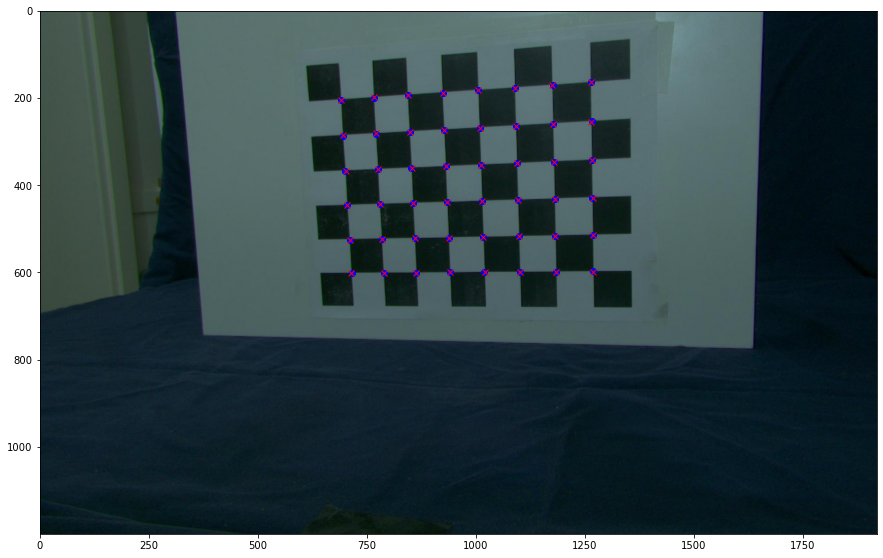

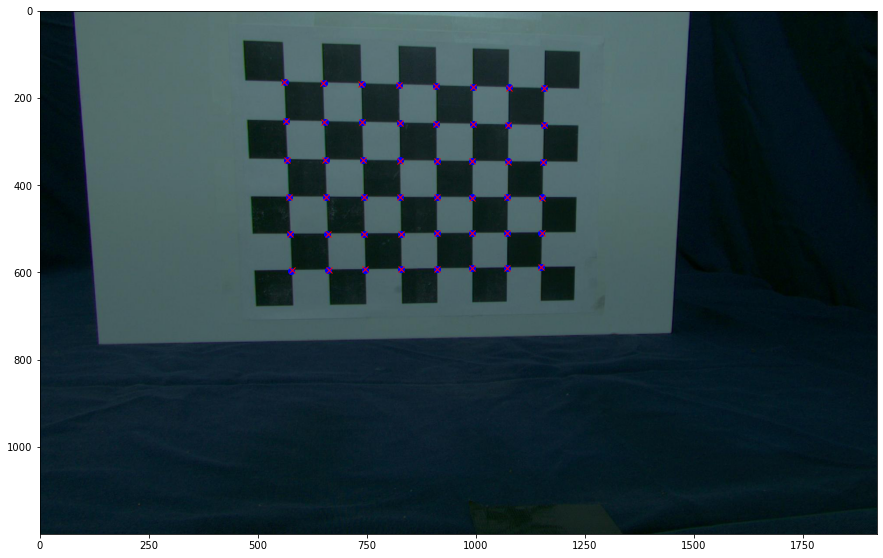

In [13]:
#ASSIGNMENT 3
# load in the intrinsic camera parameters from 'calibration.pickle'
p = pickle.load(open('calibration.pickle', 'rb'))

f = (p['fx']+p['fy'])/2
c = np.array([[p['cx']],[p['cy']]])
t = np.array([[0,0,0]]).T
R = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
camL = Camera(f, c, t, R)
camR = Camera(f, c, t, R)

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('/Users/cememirsenyurt/Desktop/CS117FINAL/calib_jpg_u/frame_C0_01.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('/Users/cememirsenyurt/Desktop/CS117FINAL/calib_jpg_u/frame_C1_01.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)


# Now use your calibratePose function to get the extrinsic parameters
# for the two images. You may need to experiment with the initialization
# in order to get a good result

#def calibratePose(pts3,pts2,cam,params_init):
params_init = np.array([0,0,0,0,0,-2]) 

camL = calibratePose(pts3, pts2L, camL, params_init)
camR = calibratePose(pts3, pts2R, camR, params_init)

print(camL)
print(camR)

# As a final test, triangulate the corners of the checkerboard to get back there 3D locations
pts3r = triangulate(pts2L,camL,pts2R,camR)

# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )



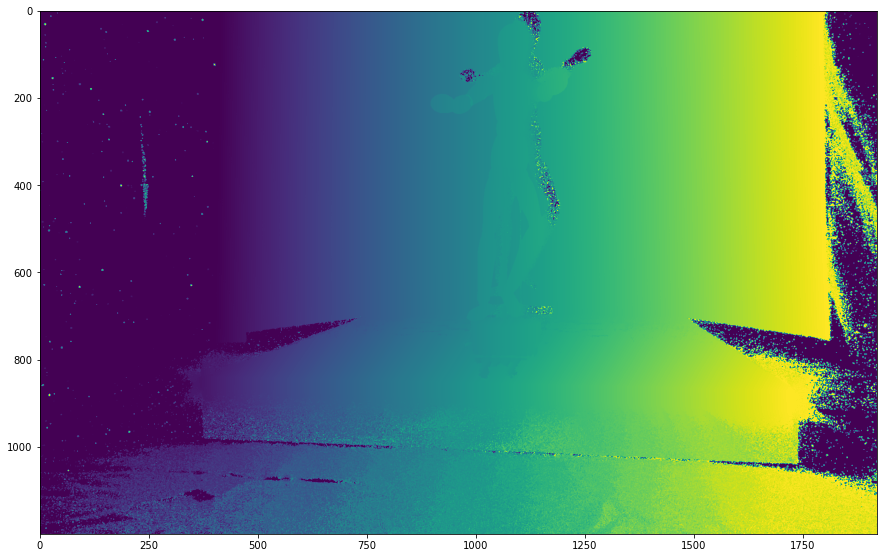

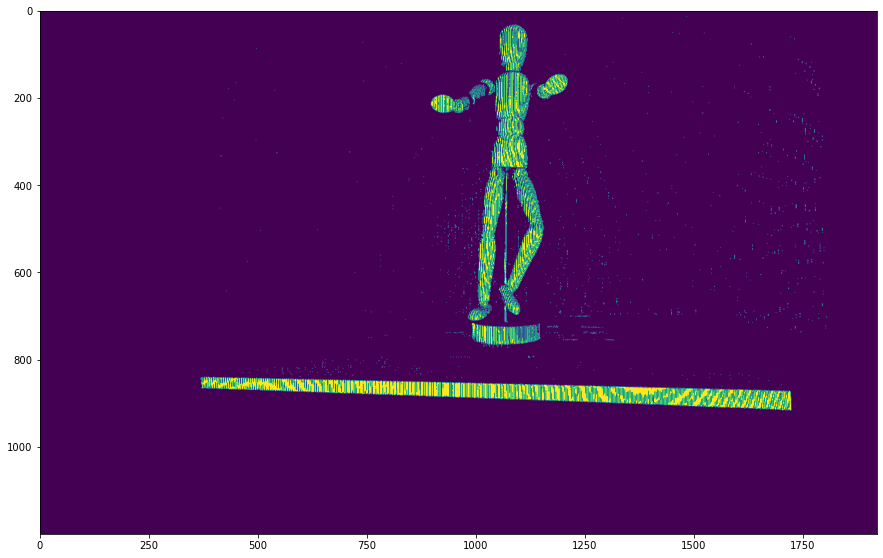

In [14]:
#
# first generate arrays containing the "true" codes projected by 
# the projector
#
# the projector had a resolution of 1280x800 so there are black bars 
# of 128 pixels on either side of our 1024 pixel region

pad = np.zeros((800,128))
hcode,vcode = np.meshgrid(range(1024),range(800))
Htrue = np.concatenate((pad,hcode,pad),axis=1)
Vtrue = np.concatenate((pad,vcode,pad),axis=1)
masktrue = np.concatenate((pad,np.ones((800,1024)),pad),axis=1)

threshold = 0.06
path = '/Users/cememirsenyurt/Desktop/CS117FINAL/manny/'
i1 = 'grab_0_u/frame_C0_'
i2 = 'grab_0_u/color_C0_'
code,mask = decode(path+i1,0,threshold)

# display view code and mask as images
plt.figure()
plt.imshow(code)
plt.show()
plt.figure()
plt.imshow(mask)
plt.show()

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



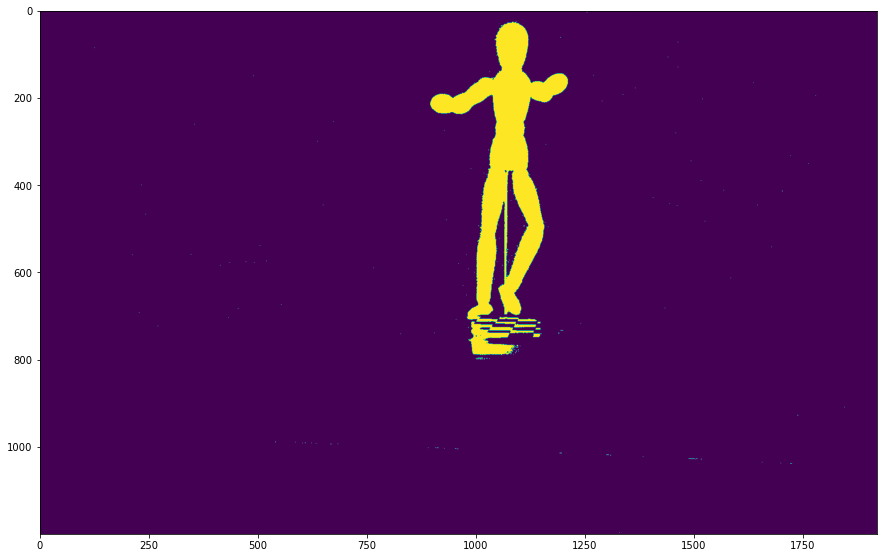

In [15]:
camC0 = camL
camC1 = camR

path = '/Users/cememirsenyurt/Desktop/CS117FINAL/manny/'
imprefixC0 = '/grab_1_u/frame_C0_'
imprefixC1 = '/grab_1_u/frame_C1_'

color_threshold = 0.006

pts2L,pts2R,pts3,color,color_mask = reconstruct(imprefixC0,imprefixC1,color_threshold,camC0,camC1, path)
plt.figure()
plt.imshow(color_mask)
plt.show()

Before meshing


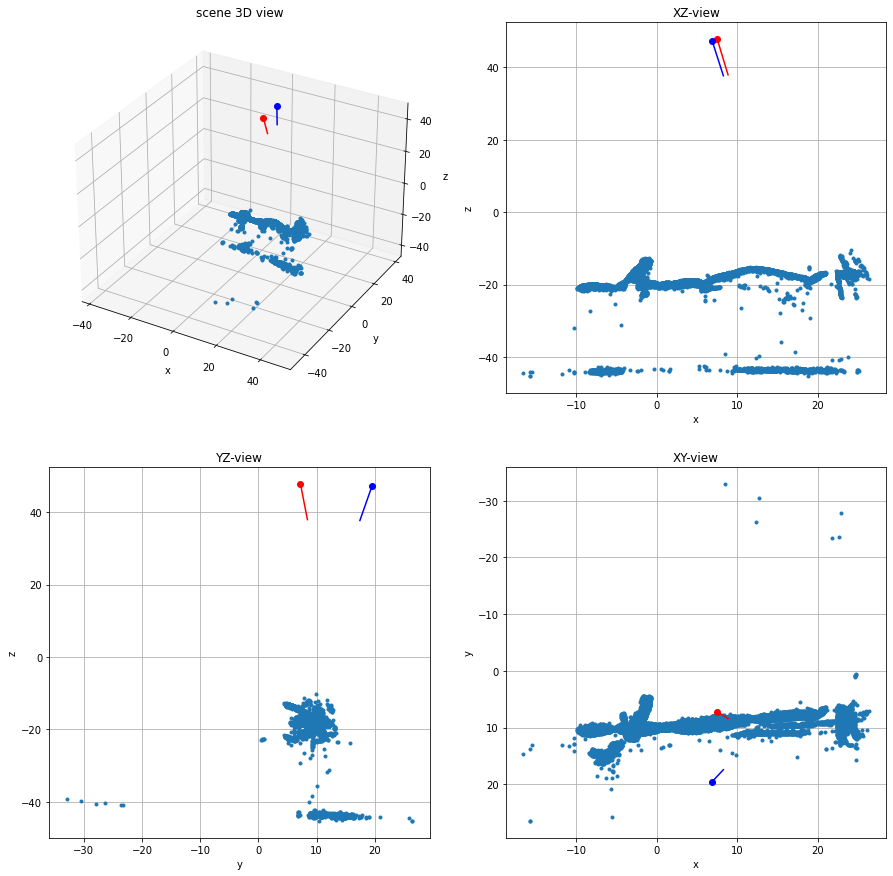

In [16]:
print("Before meshing")
vis_scene(camL,camR,pts3,looklength=10)

In [17]:
#meshing Assignment4

In [18]:
def meshing(pts2L, pts2R, pts3, color, imprefixL, imprefixR):
    boxlimits = np.array([-15,25,-7,32,-38,0])
    trithresh = 1
    
    # Bounding box pruning
    boxed_ind = []
    for i in range(pts3.shape[1]):
        x, y, z = pts3[:, i]
        if boxlimits[0] <= x <= boxlimits[1] and boxlimits[2] <= y <= boxlimits[3] and boxlimits[4] <= z <= boxlimits[5]:
            boxed_ind.append(i)
    
    # Apply Bounding Box Pruning
    pts3 = pts3[:, boxed_ind]
    pts2L = pts2L[:, boxed_ind]
    pts2R = pts2R[:, boxed_ind]
    color = color[:, boxed_ind]

    # Triangulate the 2D Points
    tri = scipy.spatial.Delaunay(pts2L.T)
    
    def prune_triangles(tri, pts3, trithresh):
        def distance(x, y, z):
            return np.linalg.norm(pts3.T[tri.simplices[x][y]] - pts3.T[tri.simplices[x][z]])

        indices_to_keep = []
        for i in range(tri.simplices.shape[0]):
            if (
                distance(i, 0, 1) <= trithresh
                and distance(i, 0, 2) <= trithresh
                and distance(i, 1, 2) <= trithresh
            ):
                indices_to_keep.append(i)

        tri.simplices = tri.simplices[indices_to_keep]

        return tri
    
    tri = prune_triangles(tri, pts3, trithresh)
    
    return pts3, pts2L, pts2R, tri, color

0
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

Before meshing

After meshing


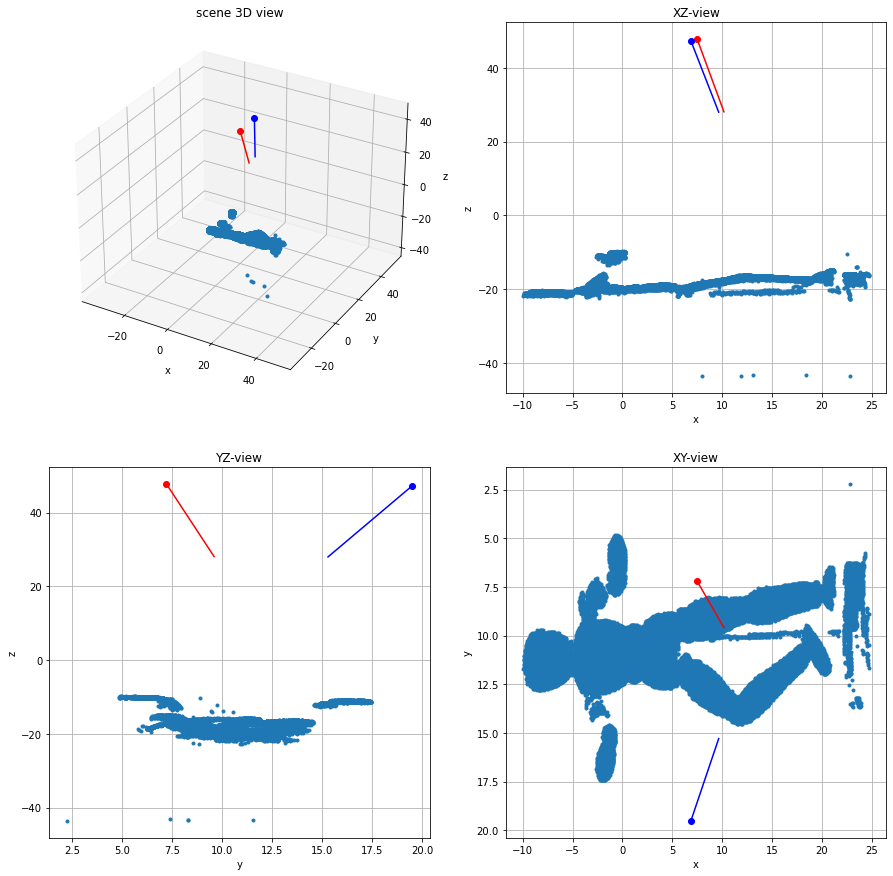

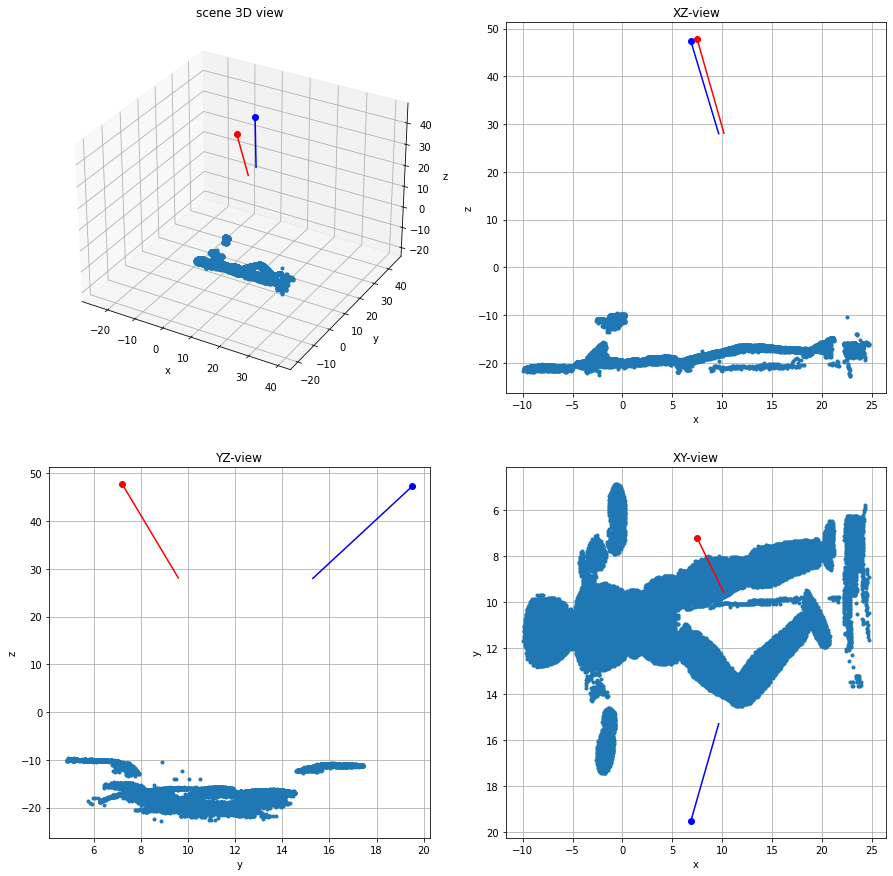

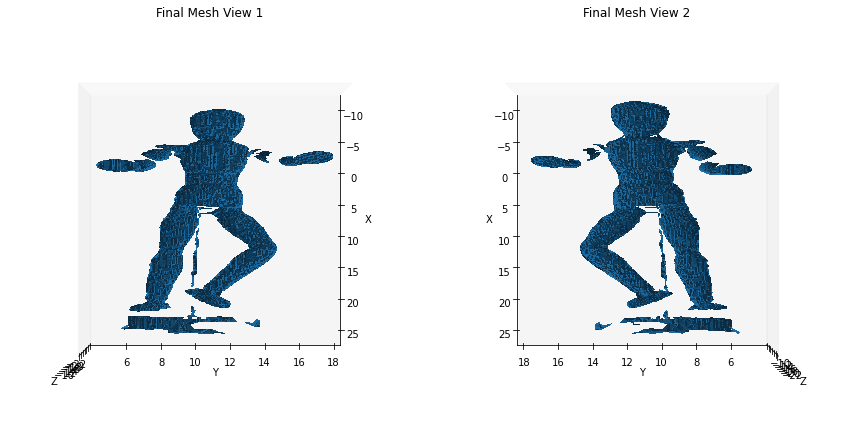

1
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

Before meshing

After meshing


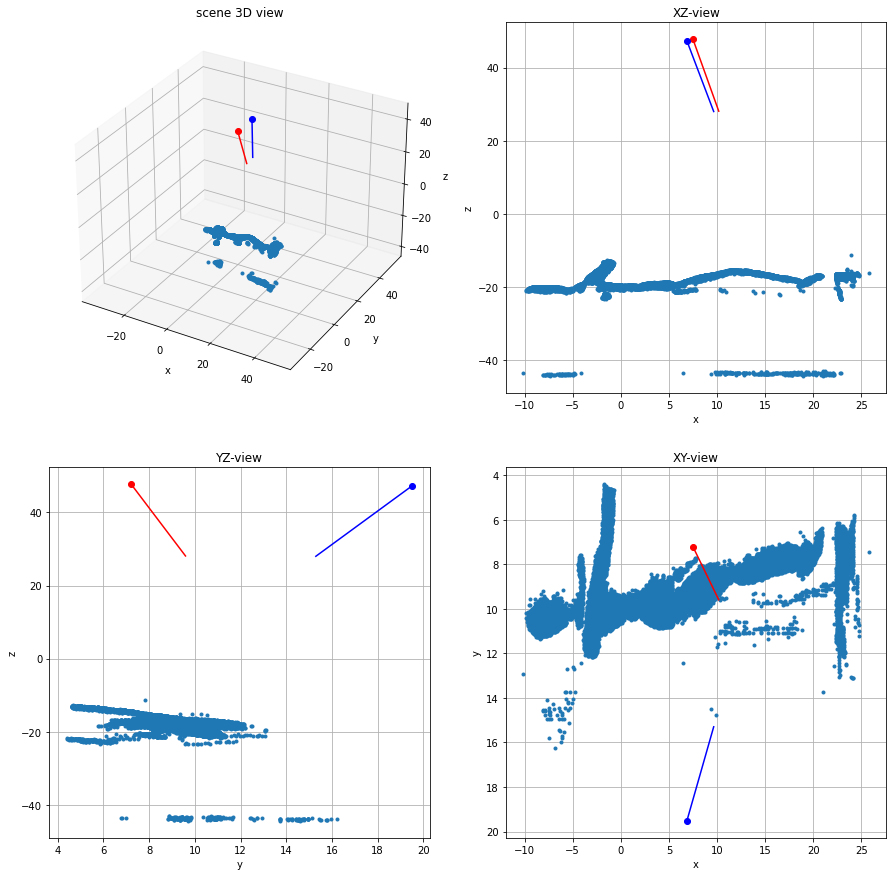

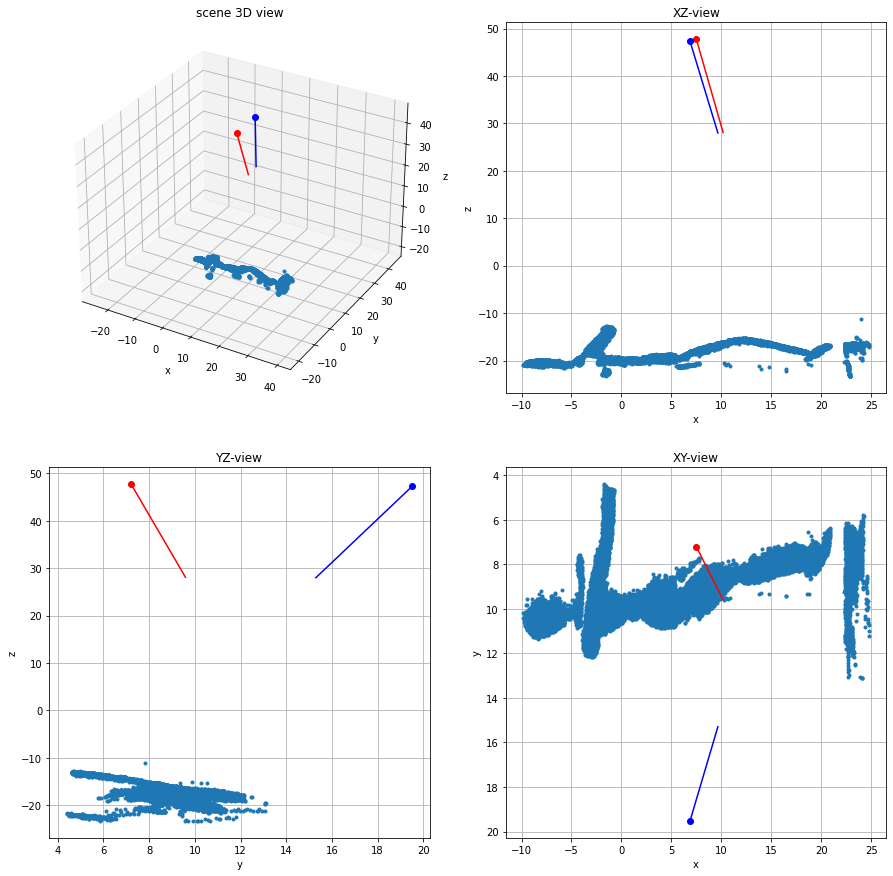

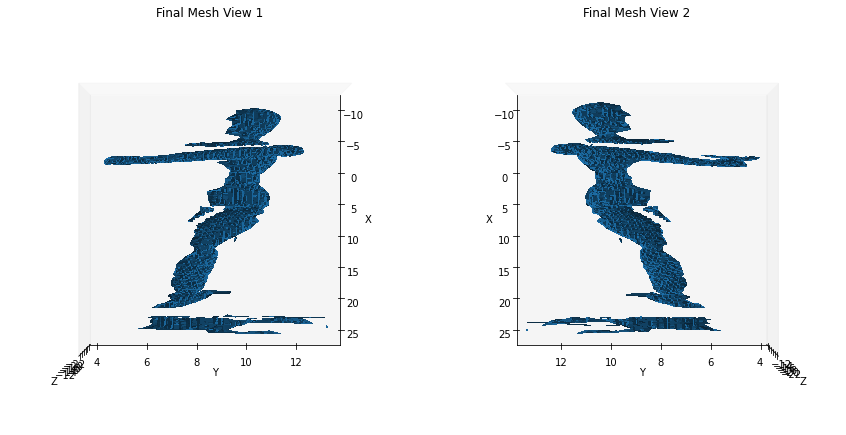

2
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

Before meshing

After meshing


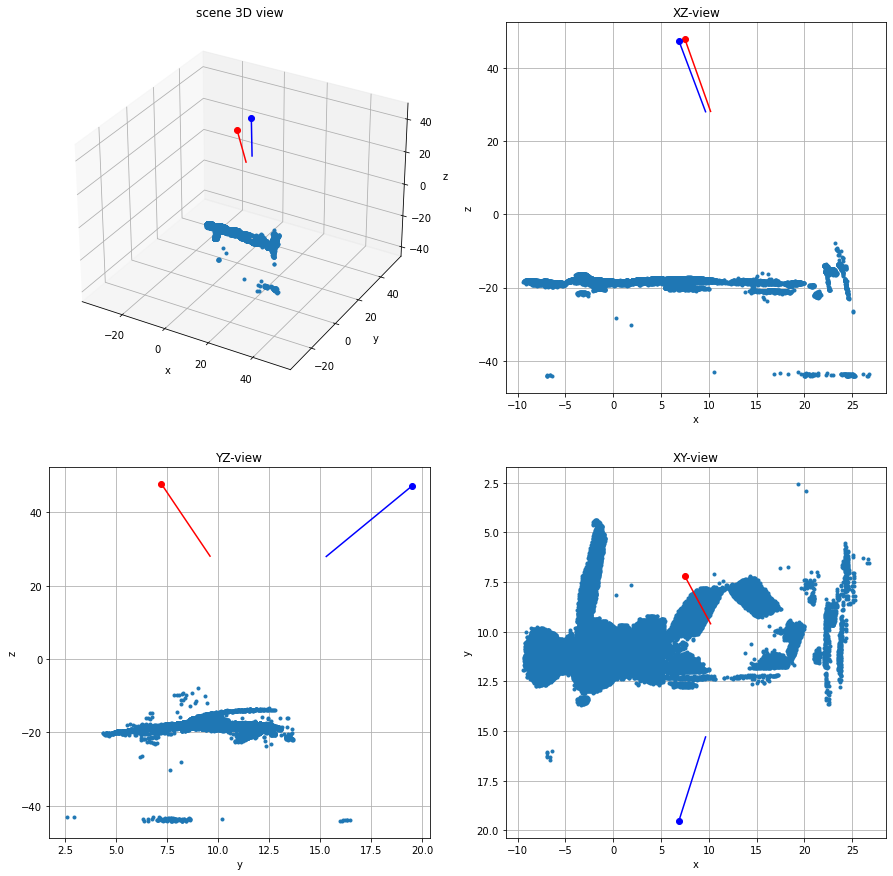

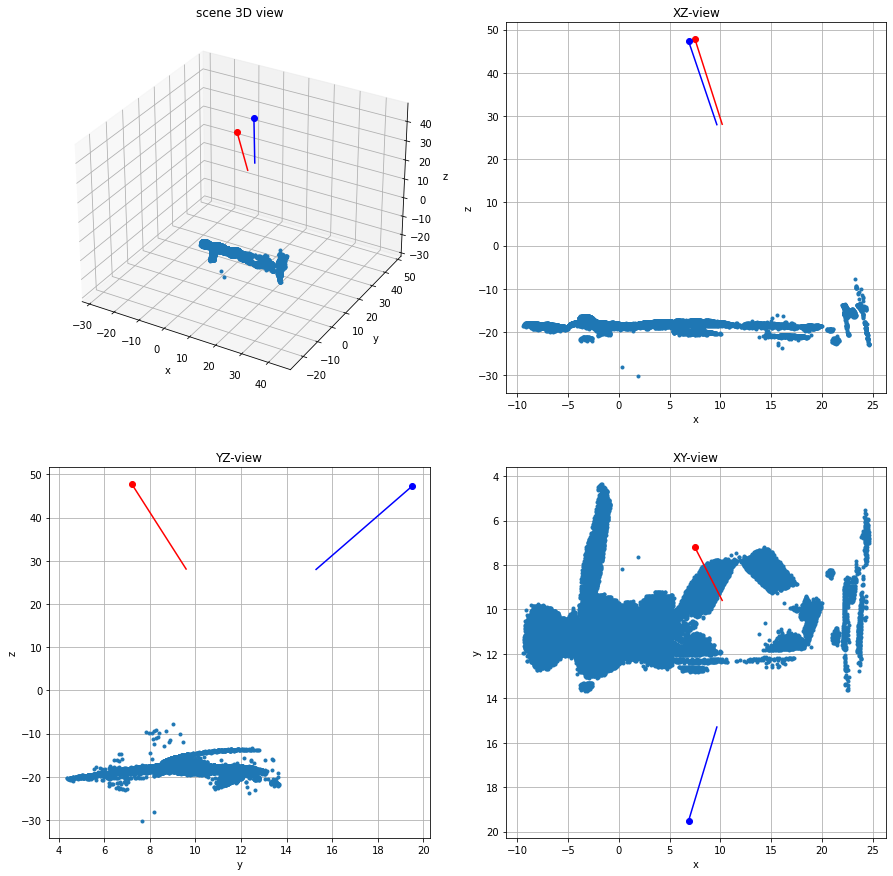

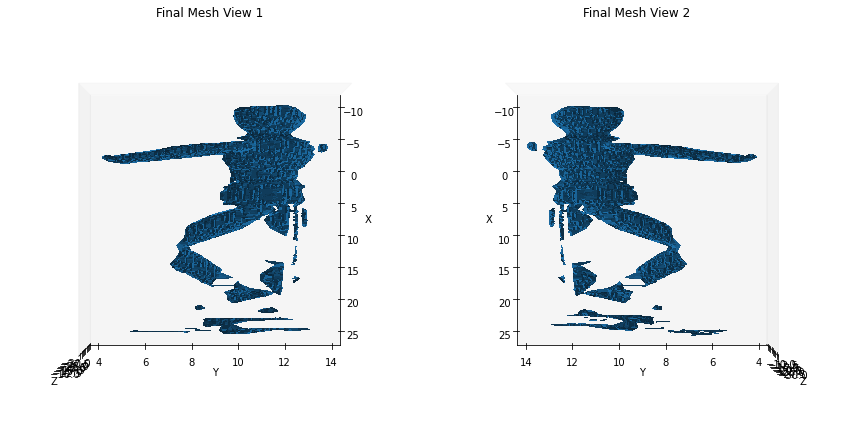

3
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

Before meshing

After meshing


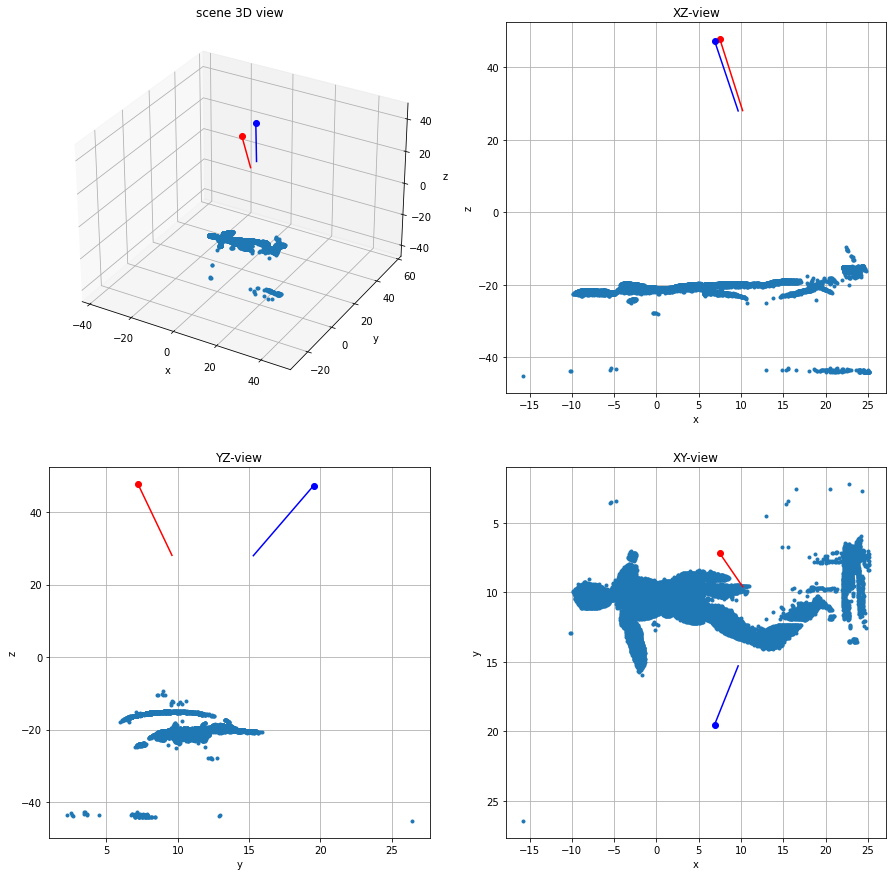

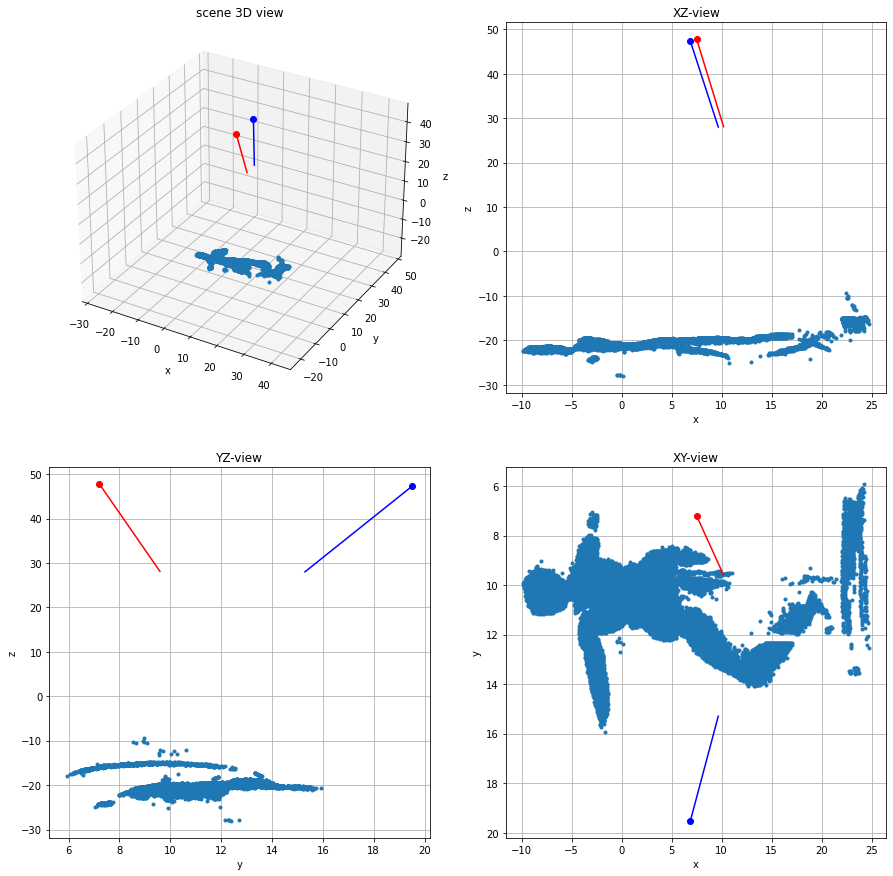

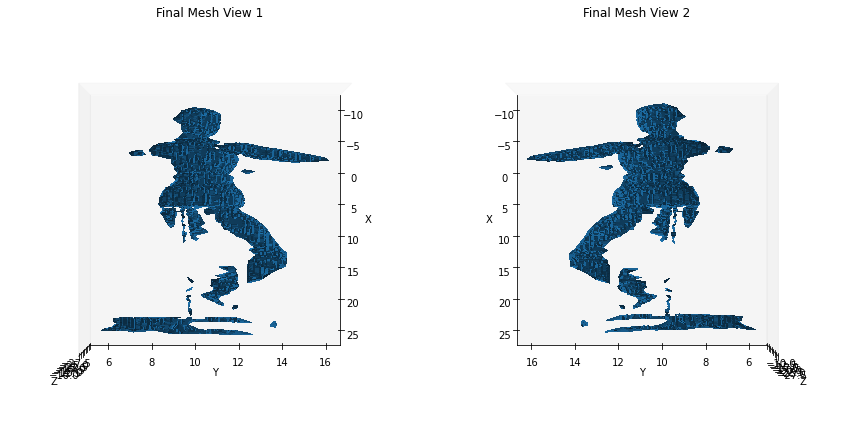

4
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

Before meshing

After meshing


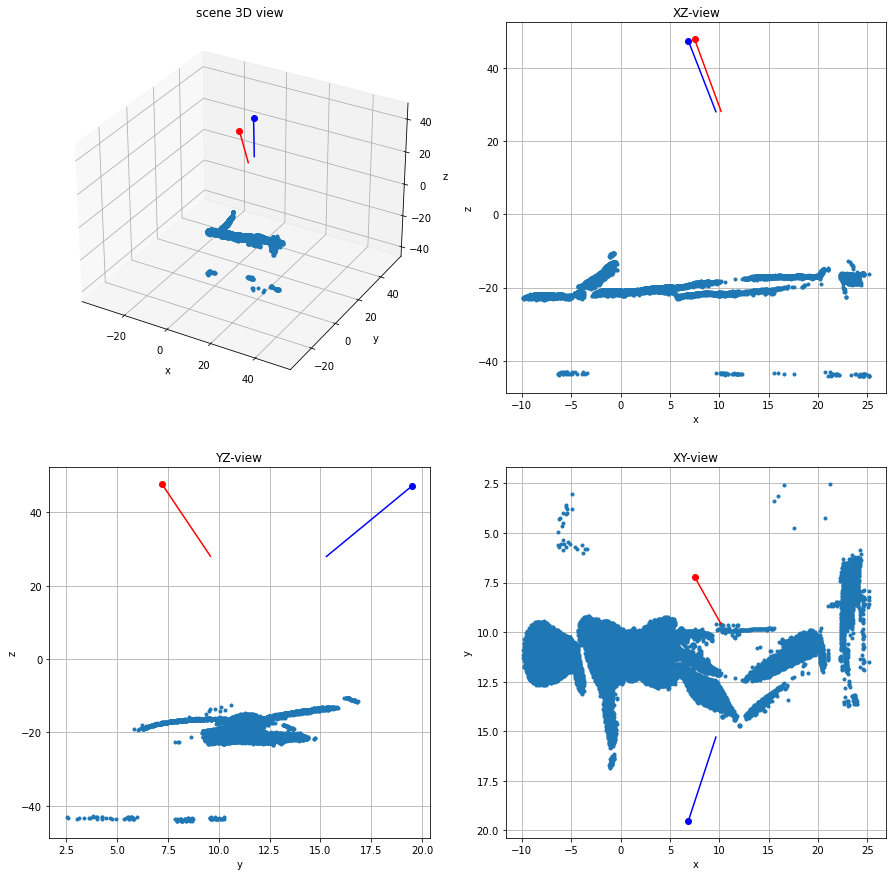

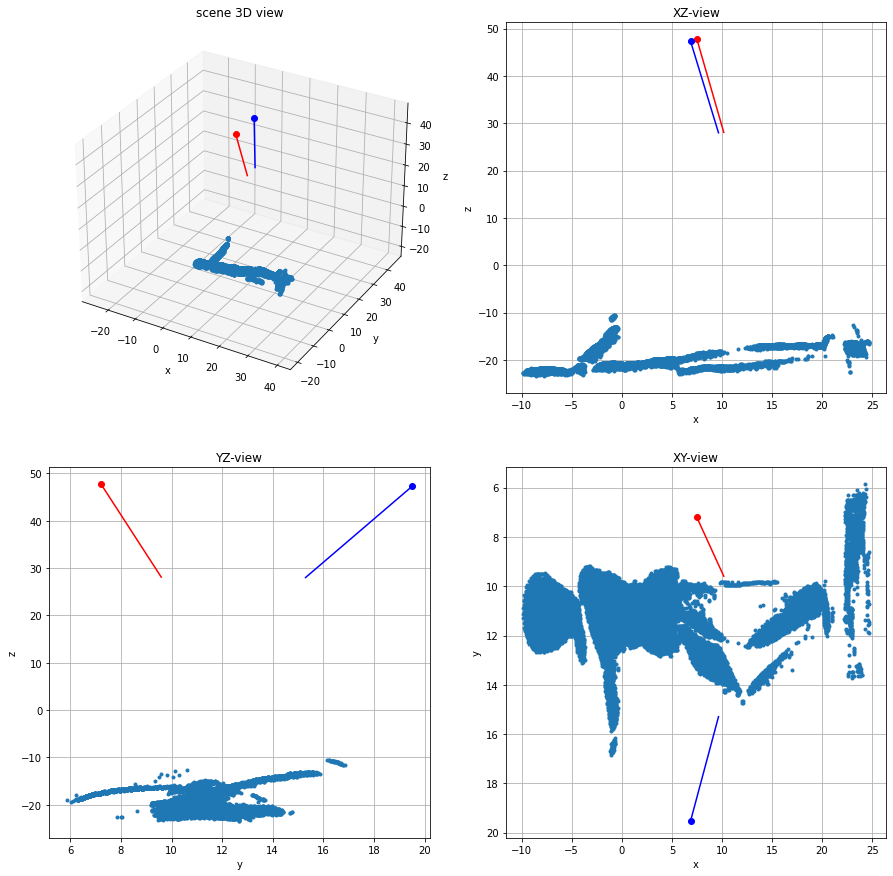

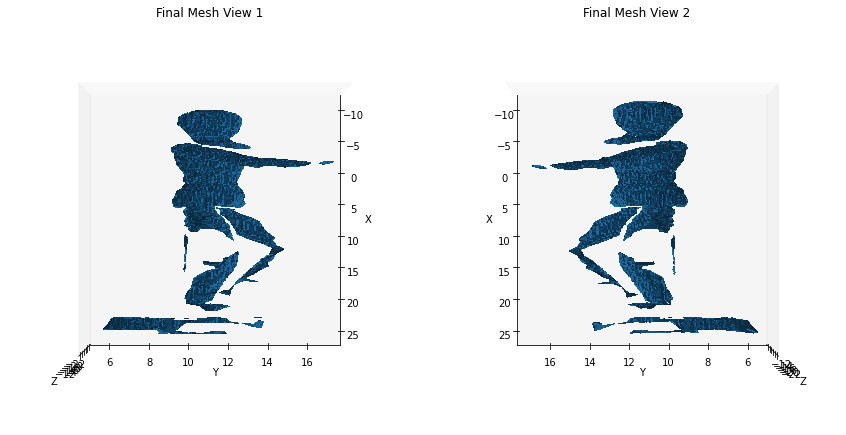

In [19]:
import trimesh
import numpy as np

for i in range(5):
    print(i)
    path = '/Users/cememirsenyurt/Desktop/CS117FINAL/manny/'
    imprefixL = f'/grab_{i}_u/frame_C0_'
    imprefixR = f'/grab_{i}_u/frame_C1_'
    threshold = 0.02
    filename = f'/Users/cememirsenyurt/Desktop/CS117FINAL/manny/manny{i}.ply'
    pts2L, pts2R, pts3, color, color_mask = reconstruct(imprefixL, imprefixR, threshold, camL, camR, path)

    print("Before meshing\n")
    vis_scene(camC0,camC1,pts3,looklength=20)
    pts3, pts2L, pts2R, tri, color = meshing(pts2L, pts2R, pts3, color, imprefixL, imprefixR)
    mesh = trimesh.Trimesh(vertices=pts3.T, faces=tri.simplices) 
    mesh.show()
    print("After meshing")
    vis_scene(camC0,camC1,pts3,looklength=20)

    fig = plt.figure(figsize=(12, 6))

    # Final Mesh View 1
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_trisurf(pts3[0, :], pts3[1, :], pts3[2, :], triangles=tri.simplices, antialiased=False)
    ax.view_init(azim=0, elev=90)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Final Mesh View 1')
    ax.grid(False)

    # Final Mesh View 2
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_trisurf(pts3[0, :], pts3[1, :], pts3[2, :], triangles=tri.simplices, antialiased=False)
    ax.view_init(azim=180, elev=270)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Final Mesh View 2')
    ax.grid(False)

    plt.tight_layout()
    plt.show()
    writeply(pts3, color, tri, filename)